In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

2023-03-03 13:18:19.737731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data(data_path,data_file,file_type="csv",unchange_indices=[],indirect_indices=[],
                direct_indices=[],id_ind=0,target_ind=-1,val_prop=0.10,test_prop=0.10,
                opt_params={},save_file=""):

    """
        data_path: Path to the data file. The output data will be written to this 
		   location.

        data_file: File containing the data to be loaded.

        file_type: The type of file, either 'csv' or 'pkl'.

                   (1 ) 'csv' assumes the following:

                         a. Has a header and is the first line in the file.
                         b. The first column identifies the instance.
                         c. The last column is the target variable.
                         d. ALL VARIABLES ARE NUMERIC (including identifiers
                            and target).

                   (2) 'pkl' file type is assumed to have been generated
                        according to this code.
        
        unchange_indices: The indices onf the unchangeable features.

        indirect_indices: The indices of the indirectly changeable features.
 
        direct_indices: The indices of the directly changeable features

        seed: Seed to randomly partition data.

        val_prop: Proportion of data to be used for the validation set.

        test_prop: Proportion of data to be used for the test set.

        imbal_classes: Boolean. Whether or not there is class imbalance. If
                       set to True, then we will stratify the positive class
                       (assumed to be the imbalanced class). To ensure that
                       positive samples are present in the train, validation,
                       and test sets.

    """

    if file_type == "pkl":
        with open(data_path+data_file,'rb') as rF:
            load_data = pkl.load(rF)
            return load_data
    
    elif file_type == "csv":
        sep=","
    else:
        raise Exception("Unsupoorted file type {}. Support file types are 'csv' and 'pkl'.".format(file_type))

    dset_df = pd.read_csv(data_path+data_file,sep=sep)

    header = dset_df.columns


    id_col_name = header[id_ind]
    target_col_name = header[target_ind]
    indirect_col_names = header[indirect_indices]
    direct_col_names = header[direct_indices]
    unchange_col_names = header[unchange_indices]

    dset_ids = dset_df[id_col_name].values
    dset_targets = dset_df[target_col_name].values
    X_data = dset_df.drop([id_col_name, target_col_name],axis=1)
    

    unchange_indices = [X_data.columns.get_loc(c) for c in unchange_col_names]
    indirect_indices = [X_data.columns.get_loc(c) for c in indirect_col_names]
    direct_indices = [X_data.columns.get_loc(c) for c in direct_col_names]

    X_data = X_data.values    


    #Define train, val, test indices according to test_prop, val_prop
    n = dset_ids.shape[0]
    train_indices = [i for i in range(int(n*(1 - test_prop - val_prop)))]
    val_indices = [i + int(n*(1 - test_prop - val_prop)) for i in range(int(n*val_prop))]
    test_indices = [i + int(n*(1 - test_prop)) for i in range(int(n*test_prop))]

    #Partition data into train,val,test according to the above defined indices
    
    #Train
    train_X = X_data[train_indices]    
    train_target = dset_targets[train_indices]
    train_ids = dset_ids[train_indices]

    #Obtain normalization values
    min_X = np.amin(train_X,axis=0)
    max_X = np.amax(train_X,axis=0) 

    #Normalize training data
    norm_train_X =np.divide(train_X - min_X,max_X - min_X)
    
   
    train_dict = {"X":norm_train_X, "target":train_target, "ids":train_ids}

    #Val
    val_X= X_data[val_indices]
    val_target = dset_targets[val_indices]
    val_ids = dset_ids[val_indices]

    #Normailze validation data
    norm_val_X = np.divide(val_X - min_X,max_X - min_X)

    val_dict = {"X":norm_val_X, "target":val_target, "ids":val_ids}

    #Test
    test_X = X_data[test_indices]
    test_target = dset_targets[test_indices]
    test_ids = dset_ids[test_indices]

    #Normalize test data
    norm_test_X = np.divide(test_X - min_X,max_X - min_X)


    test_dict = {"X":norm_test_X, "target":test_target, "ids":test_ids}


    return_dict = {'train':train_dict,
                   'val':val_dict,
                   'test':test_dict,
                   'train_indices':train_indices,
                   'val_indices':val_indices,
                   'test_indices':test_indices,
                   'min_X':min_X,
                   'max_X':max_X,
                   'opt_params':opt_params,
                   'xU_ind':unchange_indices,
                   'xI_ind':indirect_indices,
                   'xD_ind':direct_indices
                   }

    #If a save file is defined, write the defined data out.
    if save_file != "":
        with open(data_path+save_file,'wb') as sF:
            pkl.dump(return_dict,sF)

    return return_dict

In [3]:
def load_indices(data_path,util_file):
    """
        data_path: Path to data files.

        util_file: Name of the file containing the index designations, cost
                   parameters, and direction of change parameters. Should be
                    of the form:

                        index, designation, cost increase, cost decrease, direction
                      
                        e.g.:

                        0,id,,,
                        1,dir,0,2,-1
                        2,dir,3,0,1
                        3,dir,4,3,0
                        4,unch,,,
                        5,ind,,,
                         ...
                        p,target,,,

    """

    unch_indices = []
    ind_indices = []
    dir_indices = []
    cost_inc = []
    cost_dec = []
    direct_chg = []
    id_ind = -1
    target_ind = -1
    with open(data_path+util_file,'rU') as rF:
        fReader = csv.reader(rF,delimiter=',')
        for i, row in enumerate(fReader):
            if row[1] == 'id':
                id_ind = int(row[0])
            elif row[1] == 'target':
                target_ind = int(row[0])
            elif row[1] == 'ind':
                ind_indices.append(int(row[0]))
            elif row[1] == 'unch':
                unch_indices.append(int(row[0]))
            elif row[1] == 'dir':
                dir_indices.append(int(row[0]))
                cost_inc.append(int(row[2]))
                cost_dec.append(int(row[3]))
                direct_chg.append(int(row[4]))
            else:
                raise Exception("Problem loading index file. Unrecognized designation '{}' found on row\
                          {}".format(row[0],str(i+1)))

    return unch_indices,ind_indices,dir_indices,cost_inc,cost_dec,direct_chg,id_ind,target_ind

In [141]:
unch_indices,indir_indices,dir_indices,cost_inc,cost_dec,direct_chg,id_ind,target_ind = load_indices('','brazil_indices.csv')

/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_4597/1583977326.py:32: DeprecationWarning: 'U' mode is deprecated
  with open(data_path+util_file,'rU') as rF:


In [145]:
dir_indices

[18, 19, 20, 21, 22, 23, 24, 25]

In [5]:
opt_params = {'cost_inc':cost_inc,'cost_dec':cost_dec,'direct_chg':direct_chg}

In [6]:
data_dict = load_data('','brazil_weather.csv','csv',
                          unch_indices,indir_indices,dir_indices,id_ind=id_ind,
                          target_ind=target_ind,val_prop=0.10,test_prop=0.10,
                          opt_params=opt_params,save_file="")

In [7]:
train_dat = data_dict['train']
train_dat['X'].shape[1]

25

In [8]:
len(data_dict['xD_ind']+data_dict['xI_ind'])

18

In [9]:
len(data_dict['xD_ind']) + len(data_dict['xI_ind'])

18

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [11]:
in_dim = train_dat['X'].shape[1]

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True))
model.add(tf.keras.layers.Dense(units=1))

2023-03-03 13:18:28.572960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [128]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, data_dict):
        
        self.train_dat = data_dict['train']['X']
        self.val_dat = data_dict['val']['X']
        self.test_dat = data_dict['test']['X']
        
        self.label_column_indices = data_dict['xI_ind'] + data_dict['xD_ind']
        self.column_indices = data_dict['xU_ind'] + data_dict['xI_ind'] + data_dict['xD_ind']
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column indices: {self.label_column_indices}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        labels = tf.stack(
            [labels[:, :, self.column_indices[i]] for i in self.label_column_indices],
            axis=-1
        )
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col=17, max_subplots=3):
        inputs, labels = self.example

        plt.figure(figsize=(12,8))
        max_n = min(max_subplots, inputs.shape[0])

        plot_col_index = self.column_indices.index(plot_col)
        label_col_index = self.label_column_indices.index(plot_col)

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'Column {plot_col_index} [normed]')
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10
            )
            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64
            )

            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64
                )

            if n==0:
                plt.legend()

        plt.xlabel('time')
        
    def make_dataset(self, data):
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_dat)
    
    @property
    def val(self):
        return self.make_dataset(self.val_dat)
    
    @property
    def test(self):
        return self.make_dataset(self.test_dat)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [14]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, data_dict=data_dict)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column indices: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

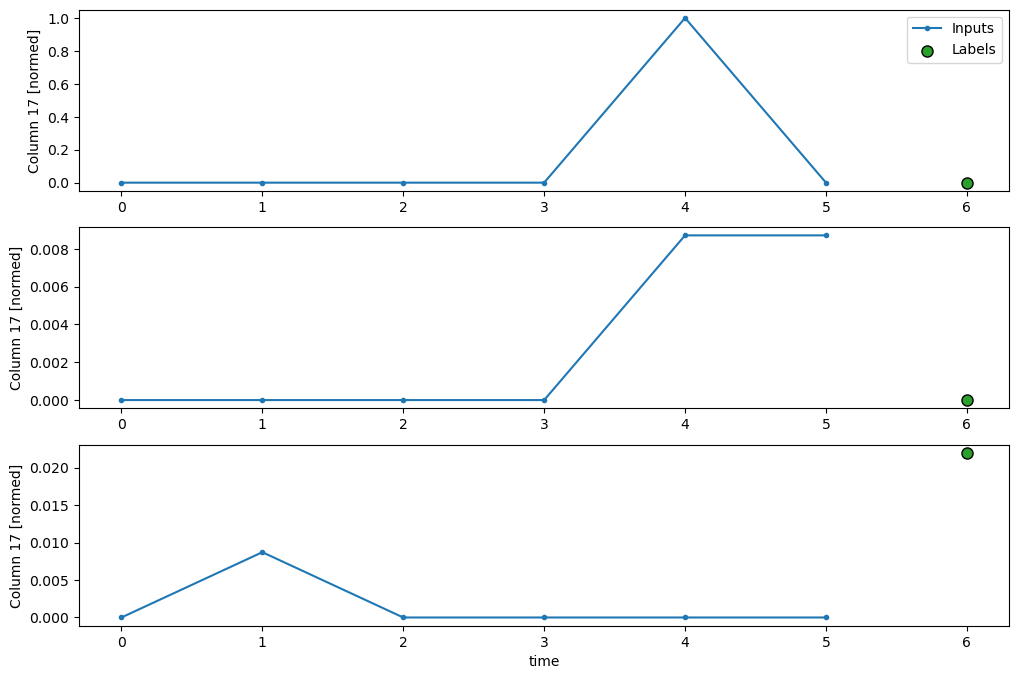

In [15]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, data_dict=data_dict)
w2.plot()

In [16]:
example_window = tf.stack([
    train_dat['X'][:w2.total_window_size],
    train_dat['X'][100:100+w2.total_window_size],
    train_dat['X'][200:200+w2.total_window_size]
])
example_window.shape

TensorShape([3, 7, 25])

In [17]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 25)
Inputs shape: (3, 6, 25)
Labels shape: (3, 1, 18)


In [18]:
example_inputs.shape[0]

3

In [19]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 25), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, 18), dtype=tf.float64, name=None))

In [20]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 25)
Labels shape (batch, time, features): (32, 1, 18)


In [21]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, data_dict=data_dict
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column indices: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

In [129]:
wide_window = WindowGenerator(
    input_width=6, label_width=6, shift=1,
    data_dict=data_dict
)

wide_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]
Label column indices: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

In [130]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=len(data_dict['xI_ind'] + data_dict['xD_ind']))
])

In [131]:
MAX_EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=2,
                                                 mode='min')

In [135]:
wide_window.val

<MapDataset element_spec=(TensorSpec(shape=(None, 6, 25), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6, 18), dtype=tf.float64, name=None))>

In [132]:
linear.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [133]:
history = linear.fit(wide_window.train, epochs=MAX_EPOCHS,
                    validation_data=wide_window.val,
                    callbacks=[early_stopping])

Epoch 1/20
17/17 [==============================] - 0s 10ms/step - loss: 0.8061 - mean_absolute_error: 0.7005 - val_loss: 0.6524 - val_mean_absolute_error: 0.6084
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5535 - mean_absolute_error: 0.5519 - val_loss: 0.4558 - val_mean_absolute_error: 0.4918
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.3878 - mean_absolute_error: 0.4482 - val_loss: 0.3253 - val_mean_absolute_error: 0.4068
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.2797 - mean_absolute_error: 0.3761 - val_loss: 0.2397 - val_mean_absolute_error: 0.3497
Epoch 5/20
17/17 [==============================] - 0s 8ms/step - loss: 0.2083 - mean_absolute_error: 0.3276 - val_loss: 0.1822 - val_mean_absolute_error: 0.3106
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.1602 - mean_absolute_error: 0.2937 - val_loss: 0.1426 - val_mean_absolute_error: 0.2809
Epoch 7/20
17/17 [=========

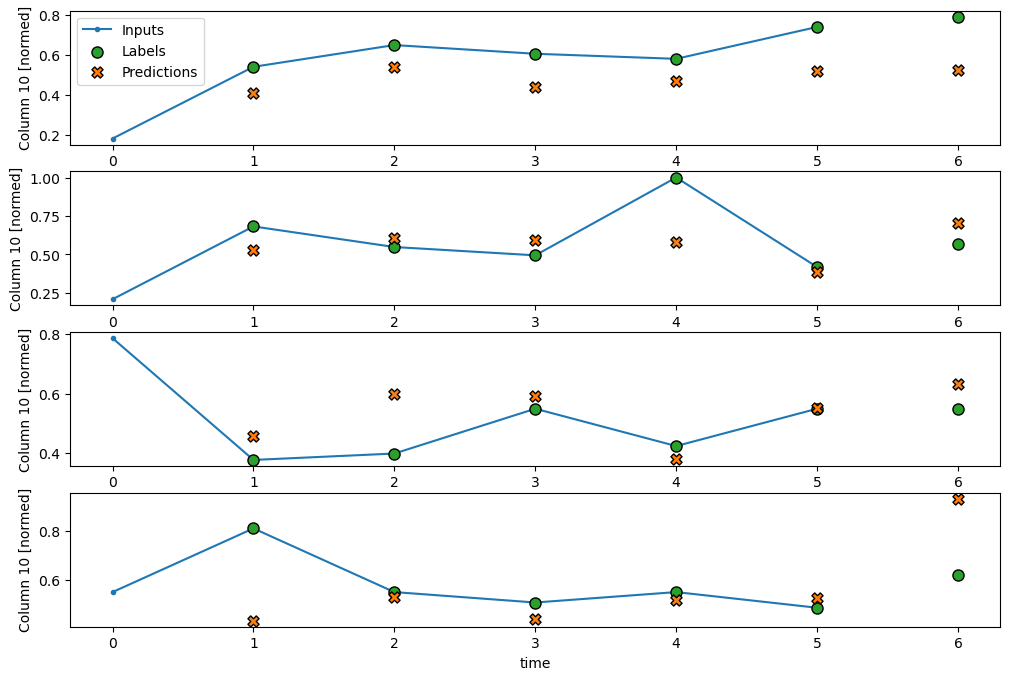

In [134]:
wide_window.plot(linear, plot_col=10, max_subplots=4)

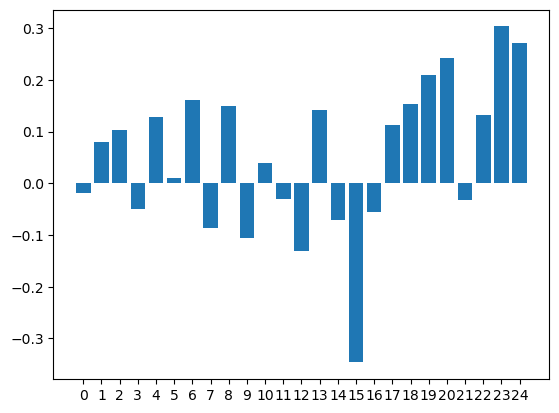

In [28]:
plt.bar(x = range(train_dat['X'].shape[1]),
    height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
_ = axis.set_xticks(range(train_dat['X'].shape[1]))

In [29]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=len(data_dict['xI_ind'] + data_dict['xD_ind']))
])

In [30]:
dense.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [31]:
history = dense.fit(wide_window.train, epochs=MAX_EPOCHS,
                    validation_data=wide_window.val,
                    callbacks=[early_stopping])

Epoch 1/20
17/17 [==============================] - 1s 19ms/step - loss: 0.2109 - mean_absolute_error: 0.3787 - val_loss: 0.0710 - val_mean_absolute_error: 0.2087
Epoch 2/20
17/17 [==============================] - 0s 8ms/step - loss: 0.0550 - mean_absolute_error: 0.1785 - val_loss: 0.0343 - val_mean_absolute_error: 0.1417
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0377 - mean_absolute_error: 0.1472 - val_loss: 0.0305 - val_mean_absolute_error: 0.1305
Epoch 4/20
17/17 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_absolute_error: 0.1385 - val_loss: 0.0290 - val_mean_absolute_error: 0.1264
Epoch 5/20
17/17 [==============================] - 0s 18ms/step - loss: 0.0330 - mean_absolute_error: 0.1348 - val_loss: 0.0286 - val_mean_absolute_error: 0.1247
Epoch 6/20
17/17 [==============================] - 0s 19ms/step - loss: 0.0320 - mean_absolute_error: 0.1325 - val_loss: 0.0283 - val_mean_absolute_error: 0.1233
Epoch 7/20
17/17 [======

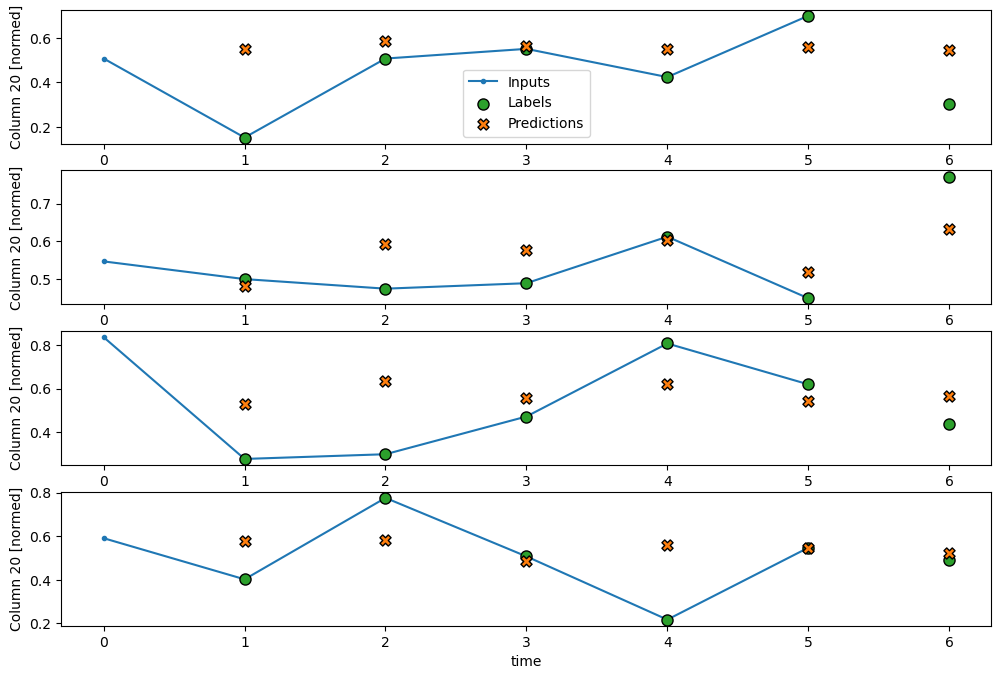

In [32]:
wide_window.plot(dense, plot_col=20, max_subplots=4)

In [33]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=len(data_dict['xI_ind'] + data_dict['xD_ind']))
])

In [34]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [35]:
history = lstm_model.fit(wide_window.train, epochs=MAX_EPOCHS,
                    validation_data=wide_window.val,
                    callbacks=[early_stopping])

Epoch 1/20
17/17 [==============================] - 4s 43ms/step - loss: 0.3211 - mean_absolute_error: 0.4932 - val_loss: 0.1729 - val_mean_absolute_error: 0.3460
Epoch 2/20
17/17 [==============================] - 0s 12ms/step - loss: 0.1290 - mean_absolute_error: 0.2890 - val_loss: 0.0736 - val_mean_absolute_error: 0.2097
Epoch 3/20
17/17 [==============================] - 0s 18ms/step - loss: 0.0656 - mean_absolute_error: 0.1940 - val_loss: 0.0512 - val_mean_absolute_error: 0.1695
Epoch 4/20
17/17 [==============================] - 0s 15ms/step - loss: 0.0504 - mean_absolute_error: 0.1685 - val_loss: 0.0443 - val_mean_absolute_error: 0.1564
Epoch 5/20
17/17 [==============================] - 0s 12ms/step - loss: 0.0444 - mean_absolute_error: 0.1572 - val_loss: 0.0398 - val_mean_absolute_error: 0.1477
Epoch 6/20
17/17 [==============================] - 0s 11ms/step - loss: 0.0404 - mean_absolute_error: 0.1496 - val_loss: 0.0366 - val_mean_absolute_error: 0.1411
Epoch 7/20
17/17 [====

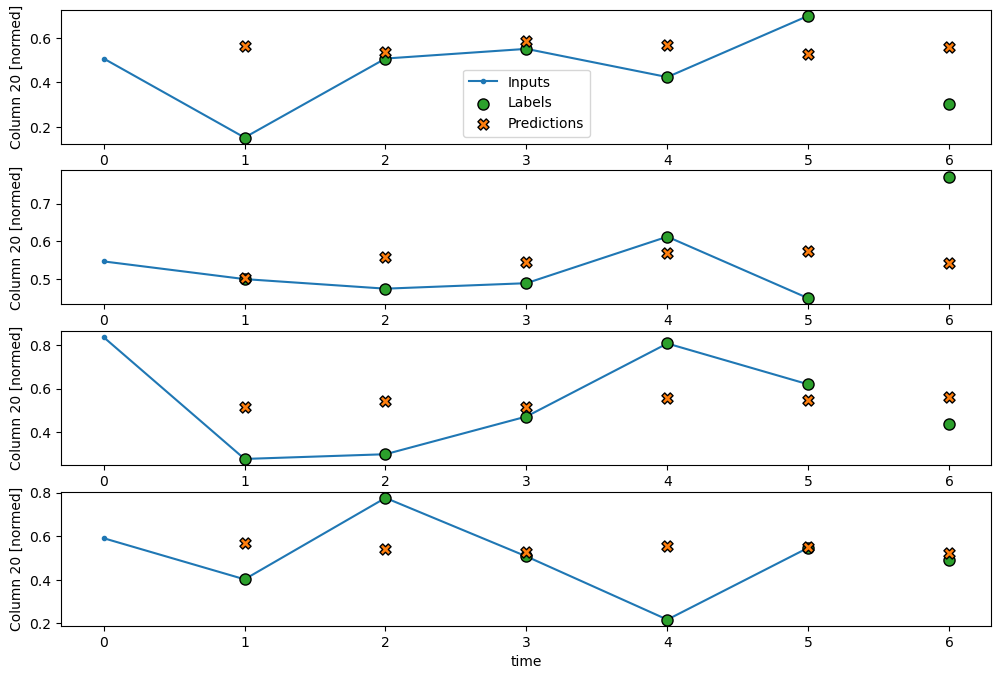

In [36]:
wide_window.plot(lstm_model, plot_col=20, max_subplots=4)

In [109]:
example_window = tf.stack([
    train_dat['X'][:wide_window.total_window_size],
    train_dat['X'][100:100+wide_window.total_window_size],
    train_dat['X'][200:200+wide_window.total_window_size]
])
example_window.shape

TensorShape([3, 7, 25])

In [110]:
example_inputs, example_labels = wide_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 25)
Inputs shape: (3, 6, 25)
Labels shape: (3, 6, 18)


In [53]:
pred = lstm_model(example_inputs)
obs = tf.cast(example_labels, dtype=tf.float32)

In [54]:
loss = tf.norm(pred - obs, ord='euclidean')
loss

<tf.Tensor: shape=(), dtype=float32, numpy=3.054397>

In [57]:
with tf.GradientTape() as t:
    t.watch(example_inputs)
    pred = lstm_model(example_inputs)
    loss = tf.norm(pred - obs, ord='euclidean')
    
    grads = t.gradient(loss,example_inputs).numpy()
    
    grads

In [63]:
example_inputs

<tf.Tensor: shape=(3, 6, 25), dtype=float64, numpy=
array([[[3.45611633e-01, 2.40606298e-01, 6.85258964e-02, 7.50000000e-01,
         6.69872981e-02, 4.52802521e-01, 9.97768193e-01, 9.12786401e-01,
         9.18898810e-01, 5.10416667e-01, 5.41516245e-01, 8.88888889e-01,
         9.07949791e-01, 9.30232558e-01, 9.29411765e-01, 5.85893144e-01,
         4.56097444e-01, 0.00000000e+00, 9.13843888e-01, 4.35791960e-03,
         5.43478261e-01, 9.27659574e-01, 9.30232558e-01, 6.05907981e-01,
         5.04984602e-01],
        [3.85821456e-01, 7.90798593e-01, 3.84860558e-01, 2.50000000e-01,
         6.69872981e-02, 4.48319513e-01, 2.67760979e-03, 6.12712491e-01,
         6.19047619e-01, 5.00000000e-01, 4.80144404e-01, 4.85596708e-01,
         4.68619247e-01, 4.88372093e-01, 4.35294118e-01, 3.77131497e-01,
         3.97608578e-01, 0.00000000e+00, 6.12665685e-01, 8.25561031e-02,
         5.32608696e-01, 4.97872340e-01, 4.30232558e-01, 4.75476980e-01,
         4.88974078e-01],
        [4.85989239e

In [111]:
window = WindowGenerator(input_width=24, label_width=24, shift=1, data_dict=data_dict)

In [122]:
x = window.train
x

<BatchDataset element_spec=TensorSpec(shape=(None, None, 25), dtype=tf.float64, name=None)>

In [119]:
for i in x:
    print(i)

TypeError: 'method' object is not iterable

In [98]:
b[:2,:2]

array([[1, 2],
       [6, 7]])

In [106]:
c = [1,2,3,4,5]
x = slice(0,None,2)
print(c[x])


[1, 3, 5]


In [115]:
lstm_model(example_inputs)

<tf.Tensor: shape=(3, 6, 18), dtype=float32, numpy=
array([[[ 6.28791273e-01,  5.78642368e-01,  5.73435247e-01,
          5.79199851e-01,  6.61755860e-01,  7.32939422e-01,
          6.81096971e-01,  6.96824431e-01,  5.27068973e-01,
          5.26156783e-01,  9.32626426e-06,  5.75343788e-01,
          4.95407507e-02,  5.84796667e-01,  7.09495604e-01,
          6.78614736e-01,  5.31546235e-01,  5.63648701e-01],
        [ 5.76259971e-01,  5.68099618e-01,  5.23241043e-01,
          5.27160823e-01,  6.18403077e-01,  6.41914427e-01,
          6.38881087e-01,  6.03406191e-01,  5.05379796e-01,
          5.15994430e-01, -3.45190614e-03,  5.54682553e-01,
          4.80782948e-02,  5.43227851e-01,  6.49821937e-01,
          5.96141279e-01,  5.03156900e-01,  5.12122750e-01],
        [ 5.77297807e-01,  5.46409130e-01,  5.52729011e-01,
          5.31955421e-01,  6.23669565e-01,  6.41525090e-01,
          6.44810200e-01,  5.86919010e-01,  4.88313735e-01,
          4.83485758e-01,  2.04369277e-02,  5.

In [139]:
data_dict

{'train': {'X': array([[0.34561163, 0.2406063 , 0.0685259 , ..., 0.93023256, 0.60590798,
          0.5049846 ],
         [0.38582146, 0.79079859, 0.38486056, ..., 0.43023256, 0.47547698,
          0.48897408],
         [0.48598924, 0.59640499, 0.58573705, ..., 0.18604651, 0.496677  ,
          0.48312646],
         ...,
         [0.24239678, 0.30273739, 0.11952191, ..., 0.58139535, 0.53086537,
          0.51663323],
         [0.22056583, 0.60419966, 0.24541833, ..., 0.56976744, 0.64262449,
          0.59621218],
         [0.68578181, 0.99999199, 0.65737052, ..., 0.36046512, 0.61243256,
          0.59941459]]),
  'target': array([ 3549.48317385,  5584.87831052,  5182.80627079,  4913.85620176,
          5697.8421744 ,  4818.79574287,  4056.79321503,  5522.6774012 ,
          5732.06933437,  5287.33793311,  5128.30962339,  5299.74769772,
          5385.60292952,  5259.62792678,  5188.84928678,  6291.33979283,
          4175.24296758,  5490.6114754 ,  4252.42740475,  7219.84592341,
       

In [146]:
X_inv = inv_data['X']

In [154]:
inp = np.array([X_inv[8-6:8]])
inp.shape

(1, 6, 25)

In [155]:
lstm_model(inp)

<tf.Tensor: shape=(1, 6, 18), dtype=float32, numpy=
array([[[ 0.61768574,  0.5572479 ,  0.5635927 ,  0.5472566 ,
          0.6536875 ,  0.65732825,  0.702982  ,  0.62727374,
          0.4816895 ,  0.4767633 ,  0.01075036,  0.5691241 ,
          0.06867362,  0.5417659 ,  0.6686737 ,  0.67183   ,
          0.5402404 ,  0.54351604],
        [ 0.5586884 ,  0.574831  ,  0.5258122 ,  0.5586741 ,
          0.65867144,  0.65948147,  0.66281396,  0.61442924,
          0.5093343 ,  0.49027282, -0.01352413,  0.5686536 ,
          0.0708321 ,  0.56451404,  0.6786134 ,  0.624912  ,
          0.4968694 ,  0.5343461 ],
        [ 0.56852853,  0.56866825,  0.5282386 ,  0.54645926,
          0.65406483,  0.6369193 ,  0.6918883 ,  0.6050372 ,
          0.52277225,  0.46816546,  0.01849042,  0.5825335 ,
          0.07691915,  0.5425261 ,  0.66033995,  0.64414245,
          0.5379104 ,  0.56523705],
        [ 0.5379575 ,  0.534005  ,  0.52665794,  0.5560019 ,
          0.65381527,  0.61885387,  0.68657756,